# RHme3: The Imposters

The manufacturer has figured out someone is using SCA on their keyfobs. They have pushed out a patch for their keyfobs changing the AES implementation. The actual AES seems to be hidden inside a number of fake AES operation. Can you still get the key?

The device expects 18 bytes of input: the first byte should be 0xAE (for encryption) followed by 16 bytes of data, followed by a newline.

In [1]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

## Explore the traces

In [2]:
# load the traceset
trs = InspectorTrace("TI-1000 + Resampled (sync) + StaticAlign + Trim.trs")

[x] Skipping unknown tag 70 with length 5
[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
[x] Skipping unknown tag 104 with length 4
[x] Skipping unknown tag 105 with length 1
[x] Skipping unknown tag 106 with length 1
Opened TI-1000 + Resampled (sync) + StaticAlign + Trim.trs, #traces 1000

Jlsca.Trs.InspectorTrace(0x2b, Nullable{Int64}(1000), 0x0020, 4, Float32, 0x00000afe, 61, IOStream(<file TI-1000 + Resampled (sync) + StaticAlign + Trim.trs>), Any[], Any[], Union, Union, 0, "TI-1000 + Resampled (sync) + StaticAlign + Trim.trs", 61, false, 2, false, Nullable{Range}())

, #samples 2814 (Float32), #data 32, #title 43


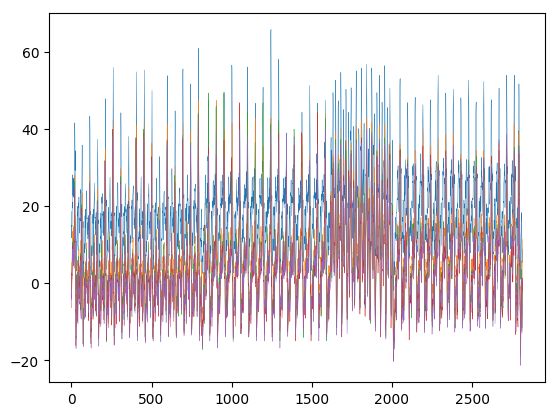

In [3]:
# read and plot 3 traces with some zoom
((data,samples),eof) = readTraces(trs, 1:5)
plot(samples[1:end,1:end]', linewidth=.3) # note the transpose; and here you can play with the zoom
; # suppress return value of plot

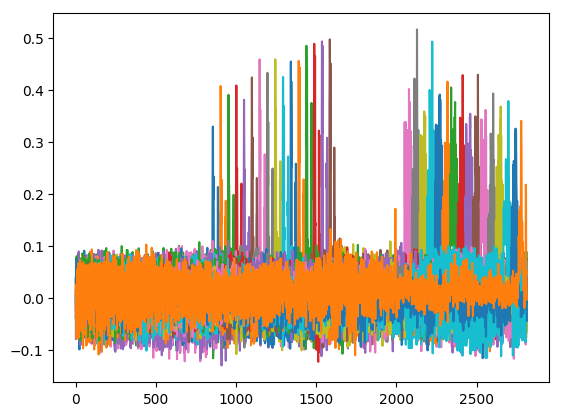

In [4]:
# Plot data correlations
((data,samples),eof) = readTraces(trs, 1:1000)
plot(cor(samples[1:end,1:end], data[:,1:32]))
; # suppress return value of plot

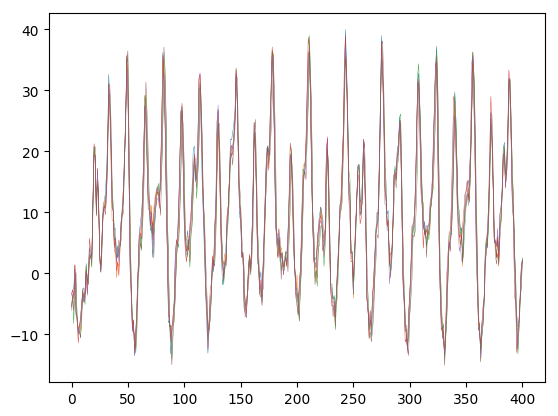

In [5]:
# Zoom in on the target area...
((data,samples),eof) = readTraces(trs, 5:10)
plot(samples[1:end,1600:2000]', linewidth=.3) # note the transpose; and here you can play with the zoom
; # suppress return value of plot

## Run correlation power analysis

This is the actual run section. I've had to extensively override to make things. work. We've got a custom attack, a custom leakage model, and we're using a new callback that I added into the main loop to get the data.

The leakage model is:  
HammingDistance(previousPlaintextByte ⊻ previousKeyByte, plaintextByte ⊻ keyByteGuess)  
= HammingWeight(previousPlaintextByte ⊻ previousKeyByte ⊻ plaintextByte ⊻ keyByteGuess)

That's really had for Jlsca to do. So we break it into parts.
* keyByteGuess is an argument to our `target` function
* we override data using a custom "DataPass" to be previousPlaintextByte ⊻ plaintextByte
* and we remember what key byte was selected for the last "target", using our new callback

Overall, there are 15 targets (key byte guesses), attacked times 256 phases. Each phase starts with an initial keybyte guess (0:255), and determines what full round-key correlates to that.

In [6]:
params = DpaAttack(AesTwoRoundAttack(), CPA())
params.ranksCallBack = twoRoundRankCallBack
params.dataOffset = 1
params.attack.direction = FORWARD

params.analysis.leakages = [HW()]
params.maximization = GlobalMaximization()
params.attack.rhme3 = true
#params.attack.xor = true # this option requires a tracecount in the ~2000 range, which we didn't provide to keep size down

range = 1600:2000
addSamplePass(trs, x -> x[range])
rankData = sca(trs, params, 1, length(trs))
popSamplePass(trs)
key = getKey(params,rankData)


Jlsca running in Julia version: 0.6.2, 1 processes/1 workers/1 threads per worker

DPA parameters
attack:       AES two-round attack
mode:       CIPHER
key length: KL128
direction:  FORWARD
known key:  UInt8[]
analysis:     CPA
leakages:     HW
maximization: global max
data at:      1

phase: 1 / 1, #targets 16

Attacking columns 1:401 out of 401 columns
CPA on samples shape (1000, 401) (range 1:401) and data shape (1000,)
Results @ 1000 rows, 401 cols (2011 rows, 401 cols, consumed)
target: 1, phase: 1, #candidates 256, "Two-round target: (Pᵢ₋₁ ⊻ Kᵢ₋₁) ⊻ (Pᵢ ⊻ Kᵢ)"
rank:   1, candidate: 0xe7, peak: 0.117603 @ 189
rank:   2, candidate: 0x62, peak: 0.117182 @ 103
rank:   3, candidate: 0x46, peak: 0.116857 @ 362
rank:   4, candidate: 0xaf, peak: 0.115415 @ 60
rank:   5, candidate: 0x37, peak: 0.112911 @ 169
recovered key material: e7
CPA on samples shape (1000, 401) (range 1:401) and data shape (1000,)
Results @ 1000 rows, 401 cols (2011 rows, 401 cols, consumed)
target: 2, phase: 1, #c

16-element Array{UInt8,1}:
 0xe7
 0xbe
 0x89
 0x84
 0x91
 0xa8
 0xdc
 0x89
 0xb3
 0x5d
 0x69
 0xe3
 0xeb
 0xb2
 0x77
 0xe6

In [7]:
# If we can trust the result of the first keybyte, and we set xor=true, the whole key should have fallen out
w = KeyExpansion(key, 10, 4)
if Cipher(trs[1][1][1:16], w) == trs[1][1][17:32]
    print("Successful decrypt with key: ",bytes2hex(key),"\n")
else
    print("Key: ",bytes2hex(key)," does not match the data\n")
end

Key: e7be898491a8dc89b35d69e3ebb277e6 does not match the data


In [8]:
# If we can't trust the first keybyte, brute force it (with xor=false)
for firstByte in 0:255
    shifted = reshape(Aes.ShiftRows(reshape(key[1:16],(4,4))), 16)
    accumulator = Array{UInt8, 1}(16)
    accumulator[1] = firstByte
    for b in 2:16
        accumulator[b] = accumulator[b-1] ⊻ shifted[b]
    end
    testkey = reshape(Aes.InvShiftRows(reshape(accumulator[1:16],(4,4))), 16) 
    
    w = KeyExpansion(testkey, 10, 4)
    if Cipher(trs[1][1][1:16], w) == trs[1][1][17:32]
        print("\nSuccessful decrypt with key: ",bytes2hex(testkey),"\n")
    else
        print(".")
    end
end

................................................................................................................................................................................................
Successful decrypt with key: c08c50d8766850d96b2b01b332d95ce7
...............................................................